In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import heapq
import psycopg2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

/usr/local/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# query = "select * from crosstab ( 'select dq.event_date, c.label, dq.close_value from company c left join daily_quote dq on c.id = dq.company_id where ibovespa_plus = true and (now() - dq.event_date) <= interval ''3 months'' order by 1, 2', 'select c.label from company c where ibovespa_plus = true order by 1') as ct ( event_date date, \"ABCB4\" numeric, \"ABEV3\" numeric, \"BBAS3\" numeric, \"BBDC3\" numeric, \"BBDC4\" numeric, \"BBSE3\" numeric, \"BRAP4\" numeric, \"BRFS3\" numeric, \"BRKM5\" numeric, \"BRML3\" numeric, \"BRSR6\" numeric, \"BTOW3\" numeric, \"CARD3\" numeric, \"CCRO3\" numeric, \"CIEL3\" numeric, \"CMIG4\" numeric, \"CPLE6\" numeric, \"CSAN3\" numeric, \"CSNA3\" numeric, \"CVCB3\" numeric, \"CYRE3\" numeric, \"ECOR3\" numeric, \"EGIE3\" numeric, \"ELET3\" numeric, \"ELET6\" numeric, \"EMBR3\" numeric, \"ENBR3\" numeric, \"EQTL3\" numeric, \"ESTC3\" numeric, \"FESA4\" numeric, \"FIBR3\" numeric, \"FLRY3\" numeric, \"FRAS3\" numeric, \"GGBR4\" numeric, \"GOAU4\" numeric, \"GOLL4\" numeric, \"GRND3\" numeric, \"HYPE3\" numeric, \"IGTA3\" numeric, \"ITSA3\" numeric, \"ITSA4\" numeric, \"ITUB3\" numeric, \"ITUB4\" numeric, \"JBSS3\" numeric, \"KLBN11\" numeric, \"KROT3\" numeric, \"LAME4\" numeric, \"LREN3\" numeric, \"MGLU3\" numeric, \"MPLU3\" numeric, \"MRFG3\" numeric, \"MRVE3\" numeric, \"MULT3\" numeric, \"NATU3\" numeric, \"PCAR4\" numeric, \"PETR3\" numeric, \"PETR4\" numeric, \"PSSA3\" numeric, \"PTBL3\" numeric, \"QUAL3\" numeric, \"RADL3\" numeric, \"RAIL3\" numeric, \"RENT3\" numeric, \"SANB11\" numeric, \"SANB4\" numeric, \"SAPR3\" numeric, \"SAPR4\" numeric, \"SBSP3\" numeric, \"SMLS3\" numeric, \"SMTO3\" numeric, \"SULA11\" numeric, \"SUZB3\" numeric, \"TAEE11\" numeric, \"TIMP3\" numeric, \"TRPL4\" numeric, \"UGPA3\" numeric, \"UNIP3\" numeric, \"UNIP6\" numeric, \"USIM5\" numeric, \"VALE3\" numeric, \"VIVT4\" numeric, \"VVAR3\" numeric, \"WEGE3\" numeric);"

In [3]:
query = """ 
    select dq.event_date, c.label, dq.close_value
    from company c
    inner join daily_quote dq on c.id = dq.company_id
    where ibovespa = true 
    and (now() - dq.event_date) <= interval '2 months'
    order by dq.event_date, c.label;"""

In [4]:
conn = psycopg2.connect(
            database="postgres",
            user="postgres",
            connect_timeout=3,
            options='-c statement_timeout=3000')
raw_df = pd.read_sql(query, conn)
# df.drop('event_date', axis=1, inplace=True)
conn.close()

In [5]:
raw_df.columns = ['Data', 'Sigla', 'Valor_de_Fechamento']
raw_df.set_index(['Data', 'Sigla'], inplace=True)

In [20]:
df_0 = (raw_df.unstack()
          .replace({0: np.NaN})
          .fillna(method='ffill')
           .dropna(how='any', axis=1))
df = df_0.copy()
df.head()
raw_df.to_csv('data/sample_data.csv')

In [7]:
# df.dropna(axis=1, how='all', inplace=True)
# df.dropna(axis=0, how='any', inplace=True)
# df.fillna(axis=1, value=0, inplace=True)

In [8]:
# scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
df[df.columns] = scaler.fit_transform(df[df.columns])
#df.head()

In [9]:
# series = df.mean()
# series2 = series[series > 0]
# series2

In [10]:
means = np.mean(df)
# print(means)
# variances = np.var(df)
# print(variances)
covariance_matrix = np.cov(df, rowvar=False)
# print(covariance_matrix)

In [11]:
def risk_profit(a):
    return np.sqrt(np.dot(np.dot(a, covariance_matrix), a)), np.sum(np.multiply(a, means))

### Função multi-objetivo
A função f tentará minimizar a variancia da carteira e maximizar o seu retorno

In [12]:
def f(x):
    return np.dot(np.dot(x, covariance_matrix), x) / np.sum(np.multiply(x, means))

In [18]:
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0}]
n = df.shape[1]
x0 = np.full(n, 1 / n)
result = minimize(f, x0, constraints=cons, method='SLSQP', options={'disp': 'True', 'maxiter': 150})
# result = minimize(f, x0, method='Powell', options={'disp': 'True', 'maxiter': 100})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.816685650444981e-06
            Iterations: 47
            Function evaluations: 2964
            Gradient evaluations: 47


### Representação visual da carteira otimizada!

risk=0.0017562203777131025, profit=0.45246475681233944


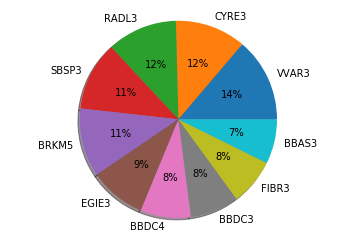

[0.1911961085754964, 0.16125005268448098, 0.15969706323775196, 0.15684284337934992, 0.1562982306442664, 0.12849574665051966, 0.11456355750963841, 0.1109338494462912, 0.10627007750075465, 0.10128861665451146]
['VVAR3', 'CYRE3', 'RADL3', 'SBSP3', 'BRKM5', 'EGIE3', 'BBDC4', 'BBDC3', 'FIBR3', 'BBAS3']


In [14]:
optimal_values = []
optimized = result.success
if optimized:
    risk, profit = risk_profit(result.x)
    #print(result.x)
    print("risk=%s, profit=%s" % (risk, profit))
    
    optimal_values = result.x

#     for k, v in enumerate(optimal_values):
#         print('k = %s, v = %s' % (k, v))
    nlargest = heapq.nlargest(10, enumerate(optimal_values), key=lambda x: x[1])
    nlargest_indexes = [i for (i, j) in nlargest]
    nlargest_values = [j for (i, j) in nlargest]
    labels = [label for (_, label) in df.columns[nlargest_indexes].values]
    fig1, ax1 = plt.subplots()
    ax1.pie(nlargest_values, labels=labels, shadow=True, autopct='%1.0f%%')
    ax1.axis('equal')
    plt.show()
    print(nlargest_values)
    print(labels)
else:
    print('FUNCTION COULD NOT BE OPTIMIZED!')

In [15]:
# [(13, 'CYRE3'), (13, 'BRKM5'), (12, 'RADL3'), (11, 'VVAR3'), (9, 'BBDC3'), (9, 'SBSP3'), (9, 'KROT3'), (8, 'EGIE3')
# (8, 'ENBR3'), (8, 'NATU3')]

Valor_de_Fechamento                                            \
Sigla                    ABEV3  BBAS3  BBDC3  BBDC4  BBSE3  BRAP4  BRFS3   
Data                                                                       
2019-01-03               16.33  48.80  36.50  40.78  28.63  29.90  21.49   
2019-01-04               16.55  48.80  36.21  40.46  28.35  31.92  21.45   
2019-01-07               16.48  48.48  36.00  40.94  27.93  32.17  21.59   
2019-01-08               16.15  47.93  36.40  41.19  27.52  31.94  22.93   
2019-01-09               16.15  47.80  37.16  41.90  27.52  32.80  22.93   

                                 ...                                       \
Sigla       BRKM5  BRML3  BTOW3  ...    SBSP3  SMLS3  SUZB3  TIMP3  UGPA3   
Data                             ...                                        
2019-01-03  48.60  13.55  43.44  ...    37.02  44.00  36.95  11.92  53.33   
2019-01-04  48.06  13.29  42.00  ...    37.86  43.96  37.64  11.98  52.97   
2019-01-07  47.72  13.21  40.14  ...    37.00  42.26  35.85  12.37  51.35   
2019-01-08  47.69  13.23  42.00  ...    37.14  41.87  36.20  12.84  50.50   
2019-01-09  48.01  13.23  42.00  ...    37.60  41.60  38.37  12.84  52.12   

                                              
Sigla       USIM5  VALE3  VIVT4 VVAR3  WEGE3  
Data                                          
2019-01-03   9.55  49.00  47.60  4.31  18.39  
2019-01-04  10.11  52.19  47.50  4.27  18.60  
2019-01-07  10.13  51.91  47.90  4.24  18.31  
2019-01-08   9.77  52.41  48.01  4.04  18.16  
2019-01-09  10.09  52.41  48.01  4.01  18.16  

[5 rows x 61 columns]